In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from scandataset import SCANDataset
from scandataloader import SCANDataLoader
from transformer import Transformer
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from hyperparam_config.hyperparam_exp23 import *

In [2]:
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')

device

'mps'

In [3]:
MAX_LEN = 50

src_vocab = [
    '<PAD>',
    '<BOS>',
    '<EOS>',
    'walk',
    'look',
    'run',
    'jump',
    'turn',
    'left',
    'right',
    'and',
    'after',
    'opposite',
    'twice',
    'thrice',
    'around',
]

tgt_vocab = [
    '<PAD>',
    '<BOS>',
    '<EOS>',
    'I_WALK',
    'I_RUN',
    'I_JUMP',
    'I_LOOK',
    'I_TURN_RIGHT',
    'I_TURN_LEFT'
]

def list_to_dict(lst):
    return {k: v for v, k in enumerate(lst)}

src_vocab = list_to_dict(src_vocab)
tgt_vocab = list_to_dict(tgt_vocab)

scandataloader = SCANDataLoader()
data = []

data.append((
    scandataloader.load_file_path(
        os.path.join('data', 'add_prim_split', f'tasks_train_addprim_turn_left.txt')
    ),
    scandataloader.load_file_path(
        os.path.join('data', 'add_prim_split', f'tasks_test_addprim_turn_left.txt')
    )
))

data.append((
    scandataloader.load_file_path(
        os.path.join('data', 'add_prim_split', f'tasks_train_addprim_jump.txt')
    ),
    scandataloader.load_file_path(
        os.path.join('data', 'add_prim_split', f'tasks_test_addprim_jump.txt')
    )
))

for exponent in range(6):
    pow2 = 2**exponent
    train_paths = []
    test_paths = []
    for i in range(1, 5):
        train_paths.append((os.path.join(
            'data', 
            'add_prim_split', 
            'with_additional_examples',
            f'tasks_train_addprim_complex_jump_num{pow2}_rep{i}.txt'
        )))
        test_paths.append((os.path.join(
            'data', 
            'add_prim_split', 
            'with_additional_examples',
            f'tasks_test_addprim_complex_jump_num{pow2}_rep{i}.txt'
        )))
    data.append((
        scandataloader.load_file_paths(train_paths),
        scandataloader.load_file_paths(test_paths)
    ))


In [4]:
def train_loop(model, optimizer, criterion, dataloader, epochs):
    model.train()
    
    for epoch in tqdm.tqdm(range(epochs)):
        total_loss = 0
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            
            output = output.view(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)

            loss = criterion(output, tgt_output)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss/len(dataloader):.4f}")

In [5]:
def eval_loop(model, dataloader):
    model.eval()

    special_tokens = [tgt_vocab['<PAD>'], tgt_vocab['<BOS>'], tgt_vocab['<EOS>']]

    start_token = tgt_vocab['<BOS>']
    end_token = tgt_vocab['<EOS>']

    total_tokens = 0
    correct_tokens = 0
    total_seq = 0
    correct_seq = 0
    
    with torch.no_grad():
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            output = model.predict(src, start_token, end_token, MAX_LEN)

            for i in range(output.size(0)):
                tgt_tokens = tgt[i].cpu().numpy()
                pred_tokens = output[i].cpu().numpy()

                for t, p in zip(tgt_tokens, pred_tokens):
                    if t not in special_tokens:
                        total_tokens += 1
                        if t == p:
                            correct_tokens += 1

                if all(t == p for t, p in zip(tgt_tokens, pred_tokens) if t not in special_tokens):
                    correct_seq += 1
                total_seq += 1

    token_accuracy = correct_tokens / total_tokens
    seq_accuracy = correct_seq / total_seq

    return token_accuracy, seq_accuracy

 50%|█████     | 1/2 [01:09<01:09, 69.91s/it]

Epoch 1, Loss: 0.5210


100%|██████████| 2/2 [02:23<00:00, 71.52s/it]

Epoch 2, Loss: 0.1281


Token-level accuracy: 0.7668607254814152, Sequence-level accuracy: 0.5695364238410596


 50%|█████     | 1/2 [00:51<00:51, 51.65s/it]

Epoch 1, Loss: 0.5886


100%|██████████| 2/2 [01:44<00:00, 52.04s/it]

Epoch 2, Loss: 0.2696


Token-level accuracy: 0.6103454620324698, Sequence-level accuracy: 0.0018167661562418895


 50%|█████     | 1/2 [02:57<02:57, 177.80s/it]

Epoch 1, Loss: 0.2308


100%|██████████| 2/2 [05:51<00:00, 175.88s/it]

Epoch 2, Loss: 0.0262


Token-level accuracy: 0.8023745892661556, Sequence-level accuracy: 0.372485399091499


 50%|█████     | 1/2 [02:54<02:54, 174.16s/it]

Epoch 1, Loss: 0.2460


100%|██████████| 2/2 [05:50<00:00, 175.18s/it]

Epoch 2, Loss: 0.0289


Token-level accuracy: 0.9689676552877021, Sequence-level accuracy: 0.8068535825545171


 50%|█████     | 1/2 [02:48<02:48, 168.22s/it]

Epoch 1, Loss: 0.2361


100%|██████████| 2/2 [05:32<00:00, 166.46s/it]

Epoch 2, Loss: 0.0261


Token-level accuracy: 0.9836272123093913, Sequence-level accuracy: 0.917943391326928


 50%|█████     | 1/2 [02:34<02:34, 154.35s/it]

Epoch 1, Loss: 0.2640


100%|██████████| 2/2 [05:07<00:00, 153.89s/it]

Epoch 2, Loss: 0.0298


Token-level accuracy: 0.9869751694982151, Sequence-level accuracy: 0.9268641205507924


 50%|█████     | 1/2 [02:32<02:32, 152.86s/it]

Epoch 1, Loss: 0.2487


100%|██████████| 2/2 [05:05<00:00, 152.63s/it]

Epoch 2, Loss: 0.0271


Token-level accuracy: 0.9979273837830954, Sequence-level accuracy: 0.9840052015604681


 50%|█████     | 1/2 [02:31<02:31, 151.99s/it]

Epoch 1, Loss: 0.2574


100%|██████████| 2/2 [05:03<00:00, 151.70s/it]

Epoch 2, Loss: 0.0290


Token-level accuracy: 0.9986804341371689, Sequence-level accuracy: 0.9962210059942663


AttributeError: 'Axes' object has no attribute 'ylim'

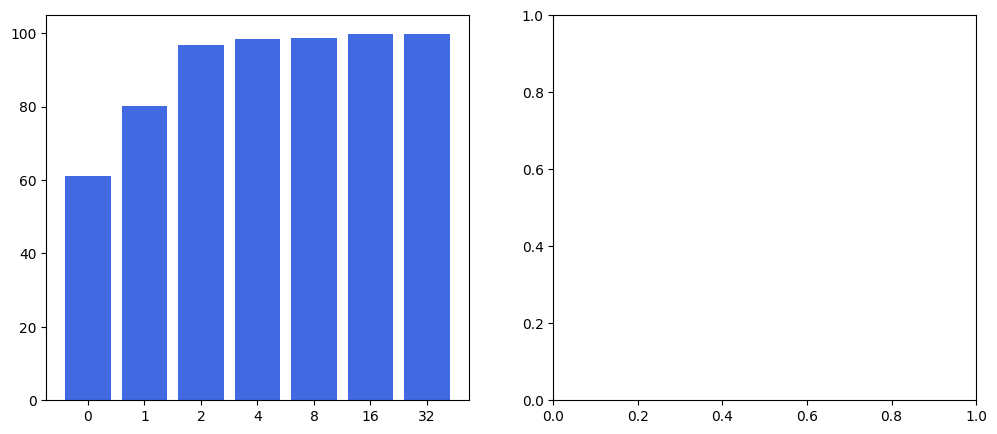

In [6]:
N = 8
epochs = 2
token_accuracies = []
seq_accuracies = []

for i in range(N):
    train_data, test_data = data[i]

    dataset_train = SCANDataset(
        data=train_data,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN,
    )

    dataset_test = SCANDataset(
        data=test_data,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN,
    )

    dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    model = Transformer(
        src_vocab_size=len(src_vocab),
        tgt_vocab_size=len(tgt_vocab),
        src_pad_idx=src_vocab['<PAD>'],
        tgt_pad_idx=tgt_vocab['<PAD>'],
        emb_dim=EMB_DIM,
        num_layers=N_LAYERS,
        num_heads=N_HEADS,
        forward_dim=FORWARD_DIM,
        dropout=DROPOUT,
        max_len=MAX_LEN,
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<PAD>'])

    train_loop(model, optimizer, criterion, dataloader_train, epochs)

    token_accuracy, seq_accuracy = eval_loop(model, dataloader_test)

    print(f'Token-level accuracy: {token_accuracy}, Sequence-level accuracy: {seq_accuracy}')

    if i > 0:
        token_accuracies.append(token_accuracy * 100)
        seq_accuracies.append(seq_accuracy * 100)

X = ['0', '1', '2', '4', '8', '16', '32']

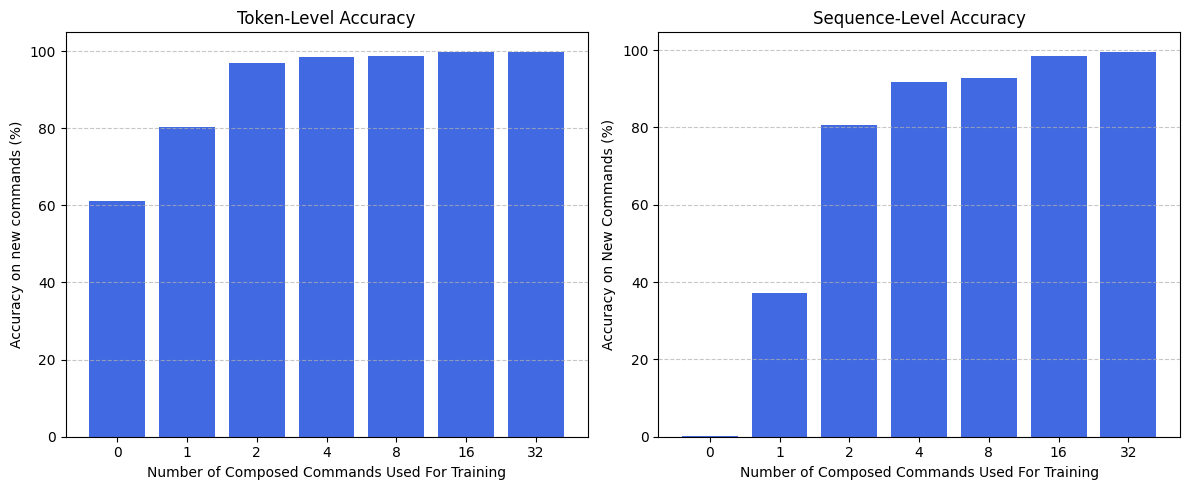

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(X, token_accuracies, color='royalblue')
axes[0].set_title("Token-Level Accuracy")
axes[0].set_xlabel("Number of Composed Commands Used For Training")
axes[0].set_ylabel("Accuracy on new commands (%)")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].bar(X, seq_accuracies, color='royalblue')
axes[1].set_title("Sequence-Level Accuracy")
axes[1].set_xlabel("Number of Composed Commands Used For Training")
axes[1].set_ylabel("Accuracy on New Commands (%)")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()